# Demo ARIMA Time Series Forecasting on Ray local

<b>Suggestion: Make a copy of this notebook.  This way you will retain the original, executed notebook outputs.  Make edits in the copied notebook. </b>

### Description:  
This notebook goes along with the tutorial <a href="https://towardsdatascience.com/scaling-time-series-forecasting-with-ray-arima-and-prophet-e6c856e605ee">How to Train Faster Time Series Forecasting Using Ray, part 1 of 2<a>.

This notebook demonstrates Time Series Forecasting ARIMA algorithm on Ray.  Example data is NYC yellow taxi from: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page  <br>

Forecast goal:  Given 6 months historical taxi trips data for NYC, your task is to predict #pickups at each location in NYC at monthly level for the next 2 months.

### Demo notes:
Output shows timings using MEDIUM dataset <br>
Both demo datasets are available in this github repo under data/  <br>
SMALL dataset contains original, actual 260 items "clean_taxi_monthly.parquet" <br>
MEDIUM dataset contains 2860 items with extra fakes "clean_taxi_monthly_fake_medium.parquet" <br>

In [ ]:
# install open-source Ray if you haven't already
# !pip install "ray[default] installs the latest version; otherwise use a specific version
# !pip install "ray[default]==1.9.0"

# install ARIMA library
# !pip install pmdarima

# install Anyscale to run Ray easily on a Cloud
# !pip install anyscale

In [1]:
###########
# Import libraries
###########

# Open-source libraries
import os  # Python os functions
import time  # Python time functions
import warnings  # Python warnings
warnings.filterwarnings('ignore')
import ray  # Run distributed code
import numpy as np  # Numerical processing
import pandas as pd  # Dataframe (tabular data) processing
import matplotlib as mpl  # Graph plotting
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# Open-source ARIMA forecasting libraries
arima_model_type = "pmdarima.arima.arima.ARIMA"
import pmdarima as pm
from pmdarima.model_selection import train_test_split

!python --version
print(f"ray: {ray.__version__}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {mpl.__version__}")
print(f"pmdarima: {pm.__version__}")
AVAILABLE_LOCAL_CPU = os.cpu_count()


Python 3.8.12
ray: 1.8.0
numpy: 1.20.3
pandas: 1.3.4
matplotlib: 3.5.0
pmdarima: 1.8.3


# Change how you want to run Ray below.  
<b>Depending on whether you want to run Ray Local or Ray in a Cloud:</b>
<ul>
    <li><b>To run Ray Local, change below variables, then continue running cells in the notebook</b>: <br>
        RUN_RAY_LOCAL = True; RUN_RAY_ON_A_CLOUD = False</li>
    <li><b>To run Ray in a Cloud, change below variables, then continue running cells in the notebook</b>: <br>
        RUN_RAY_LOCAL = False; RUN_RAY_ON_A_CLOUD = True </li>
    </ul>
      

In [11]:
###########
# CHANGE VARIABLES BELOW.
# To run Ray Local: RUN_RAY_LOCAL = True; RUN_RAY_ON_A_CLOUD = False
# To run Ray in a Cloud: RUN_RAY_LOCAL = False; RUN_RAY_ON_A_CLOUD = True
###########

RUN_RAY_LOCAL = True
RUN_RAY_ON_A_CLOUD = False

In [12]:
###########
# Run Ray Local on your laptop for testing purposes
# Dashboard doc: https://docs.ray.io/en/master/ray-dashboard.html#ray-dashboard
###########

if RUN_RAY_LOCAL:

    # num_cpus, num_gpus are optional parameters
    # by default Ray will detect and use all available
    NUM_CPU = AVAILABLE_LOCAL_CPU
    print(f"You are running Ray Local with {NUM_CPU} CPUs")

    # start up ray locally
    if ray.is_initialized():
        ray.shutdown()
    ray.init()

else:
    print("You are not running Ray Local")

You are running Ray Local


2021-11-28 20:12:07,927	INFO services.py:1270 -- View the Ray dashboard at http://127.0.0.1:8267


In [13]:
###########
# Run Ray in the Cloud using Anyscale
# View your cluster on console.anyscale.com
###########

if RUN_RAY_ON_A_CLOUD:
    print("You are running Ray on a Cloud")
    
    # !pip install anyscale  # install anyscale if you haven't already
    import anyscale

    # You can specify more pip installs, clone github, or copy code/data here in the runtime env.
    # Everything in the runtime environment will override the cluster environment.
    # https://docs.anyscale.com/user-guide/configure/dependency-management/anyscale-environments
    my_env={ "working_dir": ".",
            "pip": ["pmdarima"],
           }

    # start up ray in any cloud
    if ray.is_initialized():
        ray.shutdown()
    ray.init(
        "anyscale://christy-forecast3",
        # runtime_env=my_env,
        # optionally put pip installs in the cluster config instead of runtime_env
        cluster_env="christy-forecast:4" 
    )
    
else:
    print("You are not running Ray on a Cloud")


You are not running Ray on a Cloud


# Read 8 months clean NYC taxi data 

New York City Yellow Taxi ride volumes per location (8 months of historical data). <ul>
    <li>Original source: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page</li>
    <li>Clean monthly source:  https://github.com/christy/AnyscaleDemos/blob/main/forecasting_demos/data/clean_taxi_monthly_fake_medium.parquet?raw=true </li>
    </ul>

Normally there is a data cleaning/prep step to convert raw data -> cleaned data.  We'll dig into details of ETL later.  <br>
For now, let's just start with cleaned, aggregated monthly data for ARIMA and Prophet, since those algorithms are typically for strategic-level forecasting, not typically for detailed-level forecasting.

In [5]:
############
# Read pandas dataframe
# If you cloned this notebook from github the data should be in your data/ folder
###########
# read 8 months of clean, aggregated monthly taxi data
# filename = "https://github.com/christy/AnyscaleDemos/blob/main/forecasting_demos/data/clean_taxi_monthly_fake_medium.parquet?raw=true"
# filename = "data/clean_taxi_monthly.parquet"
filename = "data/clean_taxi_monthly_fake_medium.parquet"
g_month = pd.read_parquet(filename)

# rename "time" column, since prophet expects that, arima doesn't care
g_month.reset_index(inplace=True)
g_month.rename(columns={"pickup_monthly": "time"}, inplace=True)

display(g_month.head())

# Train a model per item_id
item_list = list(g_month["pulocationid"].unique())
print(f"Number unique items = {len(item_list)}")


,index,time,pulocationid,trip_quantity
0,0,2019-07-31,1,50
1,1,2019-07-31,10,2201
2,2,2019-07-31,100,138614
3,3,2019-07-31,101,63
4,4,2019-07-31,102,97


Number unique items = 2860


In [6]:
###########
# Assume these are already-existing functions.
###########

###########
# Define a train_model function, default train on 6 months, inference 2
###########
def train_model_ARIMA(
    theDF: pd.DataFrame,
    item_col: str,
    item_value: str,
    target_col: str,
    train_size: int = 6,
) -> list:
    """This function trains a model using ARIMA algorithm.

    Args:
        theDF (pd.DataFrame): Input data.  It must be indexed by "time".
        item_col (str): Name of the column containing item_id or SKU.
        item_value (str): Value of the item_id or SKU being forecasted.
        target_col (str): Name of the column containing the actual value.
        train_size (int, optional): Count of number of timestamps to use 
                for training. Defaults to 6.

    Returns:
        list: [
            train (pd.DataFrame):  Training data.
            test (pd.DataFrame):  Test data for evaluation.
            model (pmdarima.arima.arima.ARIMA): ARIMA model for inference.
        ]
    """

    import warnings
    warnings.filterwarnings("ignore")

    # split data into train/test
    train, test = train_test_split(
        theDF.loc[(theDF[item_col] == item_value), :], train_size=train_size
    )

    # train and fit auto.arima model
    model = pm.auto_arima(
        y=train[target_col],
        X=train.loc[:, (train.columns != target_col) & (train.columns != item_col)],
    )

    return [train, test, model]


###########
# Define inference_model function
###########
def inference_model_ARIMA(
    model: "pmdarima.arima.arima.ARIMA",
    test: pd.DataFrame,
    item_col: str,
    target_col: str,
) -> pd.DataFrame:
    """This function inferences a model using ARIMA algorithm.  It uses
                  the actual values, if known, in the test evaluation dataframe 
                  and concats them into the forecast output dataframe, 
                  for easier evaluation later.

    Args:
        model (pmdarima.arima.arima.ARIMA): ARIMA model for inference.
        test (pd.DataFrame): Test data for evaluation.
        item_col (str): Name of the column containing item_id or SKU.
        target_col (str): Name of the column containing the actual value.

    Returns:
        pd.DataFrame: Forecast as pandas dataframe containing the forecast along  
                       with actual values.
    """

    # inference on test data
    forecast = pd.DataFrame(
        model.predict(
            n_periods=test.shape[0],
            X=test.loc[:, (test.columns != target_col) & (test.columns != item_col)],
            index=test.index,
        )
    )

    # put both actual_value and predicted_value in forecast, for easier eval later
    forecast.columns = ["predicted_value"]
    forecast.predicted_value = forecast.predicted_value.astype(np.int32)
    forecast = pd.concat([forecast, test.loc[:, target_col].reset_index()], axis=1)
    forecast.set_index("time", inplace=True)

    return forecast


# Regular Python

In [ ]:
# keyboard interrupt - this takes too long!
#%%timeit
###########
# Main Regular Python program flow to train and inference ARIMA models
###########

# initialize objects
train = []
test = []
model = []
forecast = []

start = time.time()

# Train every model
train, test, model = map(
    list,
    zip(
        *(
            [
                train_model_ARIMA(
                    g_month.set_index("time"),
                    item_col="pulocationid",
                    item_value=v,
                    target_col="trip_quantity",
                    train_size=6,
                )
                for p, v in enumerate(item_list)
            ]
        )
    ),
)

# Inference every model
forecast = [
    inference_model_ARIMA(
        model[p], test[p], item_col="pulocationid", target_col="trip_quantity"
    )
    for p in range(len(item_list))
]

time_regular_python = time.time() - start
print(f"Done! ARIMA on Regular Python finished in {time_regular_python} seconds")


Done! ARIMA on Regular Python finished in 794.7754590511322 seconds
len(forecast): 2860


,predicted_value,trip_quantity
time,,
2020-01-31,47,34
2020-02-29,49,35


,predicted_value,trip_quantity
time,,
2020-01-31,1807,1689
2020-02-29,1751,1386


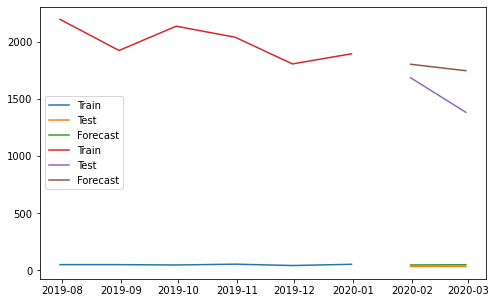

In [15]:
# Run once more without timeit to set the variables and inspect
###########
# Main Regular Python program flow to train and inference ARIMA models
###########

# initialize objects
train = []
test = []
model = []
forecast = []

start = time.time()

# Train every model
train, test, model = map(
    list,
    zip(
        *(
            [
                train_model_ARIMA(
                    g_month.set_index("time"),
                    item_col="pulocationid",
                    item_value=v,
                    target_col="trip_quantity",
                    train_size=6,
                )
                for p, v in enumerate(item_list)
            ]
        )
    ),
)

# Inference every model
forecast = [
    inference_model_ARIMA(
        model[p], test[p], item_col="pulocationid", target_col="trip_quantity"
    )
    for p in range(len(item_list))
]

time_regular_python = time.time() - start
print(f"Done! ARIMA on Regular Python finished in {time_regular_python} seconds")


###########
# inspect a few forecasts
###########

assert len(model) == len(item_list)
assert len(forecast) == len(item_list)
print(f"len(forecast): {len(forecast)}")

# plot first two forecasts
plt.figure(figsize=(8, 5))
for p, v in enumerate(item_list[0:2]):
    display(forecast[p])
    plt.plot(train[p]["trip_quantity"], label="Train")
    plt.plot(test[p]["trip_quantity"], label="Test")
    plt.plot(forecast[p]["predicted_value"], label="Forecast")
    plt.legend(loc="best")


# Ray distributed Python

In [7]:
###########
# Convert existing functions to Ray parallelized functions
###########

###########
# Define a train_model function, default train on 6 months, inference 2
###########
@ray.remote(num_returns=3)
def train_model_ARIMA_remote(
    theDF: pd.DataFrame,
    item_col: str,
    item_value: str,
    target_col: str,
    train_size: int = 6,
) -> list:
    """This function trains a model using ARIMA algorithm for use by Ray 
                  parallelization engine for distributed training on a cluster.

    Args:
        theDF (pd.DataFrame): [description]
        item_col (str): Name of the column containing item_id or SKU.
        item_value (str): Value of the item_id or SKU being forecasted.
        target_col (str): Name of the column containing the actual value.
        train_size (int, optional): Count of number of timestamps to use 
                for training. Defaults to 6.

    Returns:
        list: [
            train (pd.DataFrame):  Training data.
            test (pd.DataFrame):  Test data for evaluation.
            model (pmdarima.arima.arima.ARIMA): ARIMA model for inference.
        ]
    """

    import warnings
    warnings.filterwarnings("ignore")

    # split data into train/test
    train, test = train_test_split(
        theDF.loc[(theDF[item_col] == item_value), :], train_size=train_size
    )

    # train and fit auto.arima model
    model = pm.auto_arima(
        y=train[target_col],
        X=train.loc[:, (train.columns != target_col) & (train.columns != item_col)],
    )

    # here is the extra pickle step only required for statsmodels objects
    # Explanation why https://alkaline-ml.com/pmdarima/1.0.0/serialization.html
    # return [train, test, model]
    return [train, test, pickle.dumps(model)]


###########
# Define inference_model function
###########
@ray.remote
def inference_model_ARIMA_remote(
    model_pickle: bytes, test: pd.DataFrame, item_col: str, target_col: str
) -> pd.DataFrame:
    """This function can run on a cluster distributed by the Ray parallelization 
                  engine to inference a model using ARIMA algorithm.  It uses the 
                  actual values, if known, in the test evaluation dataframe and 
                  concats them into the forecast output dataframe, for easier 
                  evaluation later.

    Args:
        model_pickle (bytes): Serialized ARIMA model.
        test (pd.DataFrame): Ray remote reference to the pandas test dataframe.
        item_col (str): Name of the column containing item_id or SKU.
        target_col (str): Name of the column containing the actual value.

    Returns:
        pd.DataFrame: forecast is a Ray remote reference to a pandas dataframe 
                       containing the forecast along with actual values.
    """

    # Here is extra unpickle step
    model = pickle.loads(model_pickle)

    # inference on test data
    forecast = pd.DataFrame(
        model.predict(
            n_periods=test.shape[0],
            X=test.loc[:, (test.columns != target_col) & (test.columns != item_col)],
            index=test.index,
        )
    )

    # put both actual_value and predicted_value in forecast, for easier eval later
    forecast.columns = ["predicted_value"]
    forecast.predicted_value = forecast.predicted_value.astype(np.int32)
    forecast = pd.concat([forecast, test.loc[:, target_col].reset_index()], axis=1)
    forecast.set_index("time", inplace=True)

    return forecast


In [17]:
#%%timeit
###########
# Main Ray distributed program flow to train and inference ARIMA models
###########

model = []
train = []
test = []
forecast_obj_refs = []

# initialize data in ray object store on each cluster
input_data_ref = ray.put(g_month.set_index("time"))

start = time.time()

# Train every model
train, test, model = map(
    list,
    zip(
        *(
            [
                train_model_ARIMA_remote.remote(
                    input_data_ref,
                    item_col="pulocationid",
                    item_value=v,
                    target_col="trip_quantity",
                    train_size=6,
                )
                for p, v in enumerate(item_list)
            ]
        )
    ),
)

# Inference every model
forecast_obj_refs = [
    inference_model_ARIMA_remote.remote(
        model[p], test[p], item_col="pulocationid", target_col="trip_quantity"
    )
    for p in range(len(item_list))
]


# ray.get() means block until all objectIDs requested are available
forecast_ray = ray.get(forecast_obj_refs)

time_ray_local = time.time() - start
print(f"Done! ARIMA on Ray Local finished in {time_ray_local} seconds")


Done! ARIMA on Ray Local finished in 91.51533198356628 seconds


# Verify forecasts

In [18]:
# Run the Ray local code again to get the forecasts
###########
# Main Ray distributed program flow to train and inference ARIMA models
###########

model = []
train = []
test = []
forecast_obj_refs = []

# initialize data in ray object store on each cluster
input_data_ref = ray.put(g_month.set_index("time"))

start = time.time()

# Train every model
train, test, model = map(
    list,
    zip(
        *(
            [
                train_model_ARIMA_remote.remote(
                    input_data_ref,
                    item_col="pulocationid",
                    item_value=v,
                    target_col="trip_quantity",
                    train_size=6,
                )
                for p, v in enumerate(item_list)
            ]
        )
    ),
)

# Inference every model
forecast_obj_refs = [
    inference_model_ARIMA_remote.remote(
        model[p], test[p], item_col="pulocationid", target_col="trip_quantity"
    )
    for p in range(len(item_list))
]


# ray blocking step, to get the forecasts
# ray.get() means block until all objectIDs requested are available
forecast_ray = ray.get(forecast_obj_refs)

time_ray_local = time.time() - start
print(f"Done! ARIMA on Ray Local finished in {time_ray_local} seconds")


(train_model_ARIMA_remote pid=13174) 
Done! ARIMA on Ray Local finished in 91.34718608856201 seconds


In [19]:
# Calculate speedup:
speedup = time_regular_python / time_ray_local
print(f"Speedup from running Ray parallel code on your laptop: {np.round(speedup, 1)}x"
      f", or {(np.round(speedup, 0)-1) * 100}%")


Speedup from running Ray parallel code on your laptop: 8.7x, or 800.0%


In [20]:
# Verify ray forecast is same as regular Python forecast

assert len(forecast_ray) == len(forecast)
assert len(forecast_ray[0]) == len(forecast[0])
assert forecast_ray[0].equals(forecast[0])


len(forecast): 2860


,predicted_value,trip_quantity
time,,
2020-01-31,47,34
2020-02-29,49,35


,predicted_value,trip_quantity
time,,
2020-01-31,1807,1689
2020-02-29,1751,1386


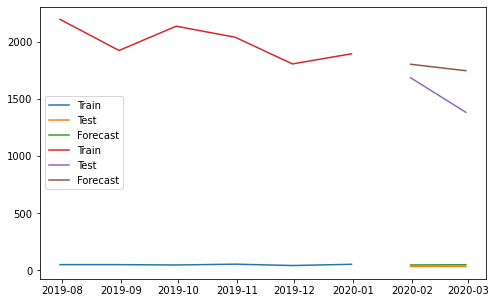

In [21]:
###########
# inspect a few forecasts
###########

assert len(model) == len(item_list)
assert len(forecast) == len(item_list)
print(f"len(forecast): {len(forecast_ray)}")

# plot first two forecasts
train = ray.get(train)
test = ray.get(test)
plt.figure(figsize=(8, 5))
for p in range(len(item_list[0:2])):
    display(forecast_ray[p])
    plt.plot(train[p]["trip_quantity"], label="Train")
    plt.plot(test[p]["trip_quantity"], label="Test")
    plt.plot(forecast_ray[p]["predicted_value"], label="Forecast")
    plt.legend(loc="best")


Forecast for item 1:


,predicted_value,trip_quantity
time,,
2020-01-31,47,34
2020-02-29,49,35


Forecast for item 10:


,predicted_value,trip_quantity
time,,
2020-01-31,1807,1689
2020-02-29,1751,1386


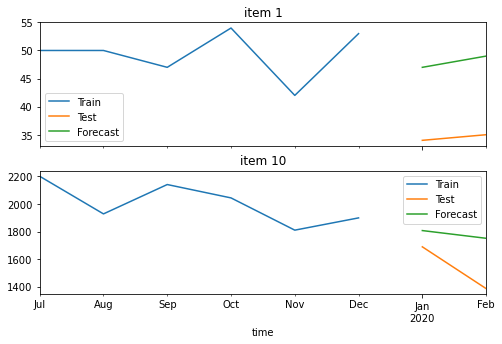

In [22]:
# fancier plots
# plot first two forecasts
fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
for p, v in enumerate(item_list[0:2]):
    print(f"Forecast for item {v}:")
    display(forecast_ray[p])

    ax = axs[p]
    train[p].trip_quantity.plot(ax=ax, label="Train")
    test[p].trip_quantity.plot(ax=ax, label="Test")
    forecast_ray[p].predicted_value.plot(ax=ax, label="Forecast")
    ax.legend(loc="best")
    ax.set_title(f"item {v}")


In [23]:
###########
# verify intermediate model artifacts, if desired
###########

# ray.get the model artifacts, in case you want to check them
model = ray.get(model)
assert len(train) == len(test)
assert len(train) == len(model)

# verify types of objects you got back from ray...
for p in range(len(item_list[0:1])):  # just look at first in the list
    print(f"type(train[{p}]): {type(train[p])}")
    print(f"type(test[{p}]): {type(test[p])}")
    display(train[p])
    display(test[p])

    print()
    print(f"type(model[{p}]) before unpickling: {type(model[p])}")
    model[p] = pickle.loads(model[p])
    print(f"type(model[{p}]) after unpickling: {type(model[p])}")
    display(model[p])


type(train[0]): <class 'pandas.core.frame.DataFrame'>
type(test[0]): <class 'pandas.core.frame.DataFrame'>


,index,pulocationid,trip_quantity
time,,,
2019-07-31,0,1,50
2019-08-31,260,1,50
2019-09-30,520,1,47
2019-10-31,780,1,54
2019-11-30,1040,1,42
2019-12-31,1300,1,53


,index,pulocationid,trip_quantity
time,,,
2020-01-31,1560,1,34
2020-02-29,1820,1,35



type(model[0]) before unpickling: <class 'bytes'>
type(model[0]) after unpickling: <class 'pmdarima.arima.arima.ARIMA'>


ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

# Now run the same code as Ray Local, but this time run using Anyscale in any Cloud.  

<b>
<ol>
    <li>Go back to top of notebook </li>
    <li>Change variables RUN_RAY_LOCAL = False; RUN_RAY_ON_A_CLOUD = True <br>
        ... And run the next 2 cells to propertly shutdown/start Ray </li>
    <li>Come back here to bottom of notebook <br>
        Run cell below.</li>
    </ul>
</b>

In [9]:
%%timeit
###########
# Main Ray distributed program flow to train and inference ARIMA models
###########

model = []
train = []
test = []

# This step required for Ray 1.8 and below
# initialize data in ray object store on each cluster
input_data_ref = ray.put(g_month.set_index("time"))

start = time.time()

# Train every model
train, test, model = map(
    list,
    zip(
        *(
            [
                train_model_ARIMA_remote.remote(
                    input_data_ref,
                    item_col="pulocationid",
                    item_value=v,
                    target_col="trip_quantity",
                    train_size=6,
                )
                for p, v in enumerate(item_list)
            ]
        )
    ),
)

# Inference every model
forecast_obj_refs = [
    inference_model_ARIMA_remote.remote(
        model[p], test[p], item_col="pulocationid", target_col="trip_quantity"
    )
    for p in range(len(item_list))
]


# ray blocking step, to get the forecasts
# ray.get() means block until all objectIDs requested are available
forecast_ray = ray.get(forecast_obj_refs)

time_ray_cloud = time.time() - start
print(f"Done! ARIMA on Ray in Cloud finished in {time_ray_cloud} seconds")


(train_model_ARIMA_remote pid=292, ip=10.0.24.81) 
Done! ARIMA on Ray in Cloud finished in 48.87350296974182 seconds
(train_model_ARIMA_remote pid=275, ip=10.0.19.137) 
Done! ARIMA on Ray in Cloud finished in 26.005599975585938 seconds
(train_model_ARIMA_remote pid=298, ip=10.0.29.190) 
(inference_model_ARIMA_remote pid=174, ip=10.0.19.137) 
(inference_model_ARIMA_remote pid=72, ip=10.0.22.126) 
Done! ARIMA on Ray in Cloud finished in 18.885366916656494 seconds
Done! ARIMA on Ray in Cloud finished in 18.496169090270996 seconds
(train_model_ARIMA_remote pid=304, ip=10.0.22.145) 
Done! ARIMA on Ray in Cloud finished in 18.069195985794067 seconds
(inference_model_ARIMA_remote pid=391, ip=10.0.24.81) 
(inference_model_ARIMA_remote pid=391, ip=10.0.24.81) 
(train_model_ARIMA_remote pid=239, ip=10.0.24.81) 
Done! ARIMA on Ray in Cloud finished in 19.14598774909973 seconds
(inference_model_ARIMA_remote pid=404, ip=10.0.28.164) 
(inference_model_ARIMA_remote pid=360, ip=10.0.43.40) 
(inference

Log channel is reconnecting. Logs produced while the connection was down can be found on the head node of the cluster in `ray_client_server_[port].out`
Encountered connection issues in the data channel. Attempting to reconnect.
Failed to reconnect the data channel


In [10]:
time_ray_cloud = 23

In [24]:
# Calculate speedup running parallel Python Ray in a Cloud:
speedup = time_regular_python / time_ray_cloud
print(f"Speedup from running Ray parallel code in a Cloud: {np.round(speedup, 1)}x"
      f", or {(np.round(speedup, 0)-1) * 100}%")


Speedup from running Ray parallel code in a Cloud: 34.6x, or 3400.0%


In [25]:
ray.shutdown()